In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
import geopandas as gpd
import fiona
import networkx as nx


In [17]:
# Sample bounding boxes (From Google Maps Geocoding API)
bboxes = {
    'london': [51.38494,-0.351468,51.672343,0.148271],
    'birmingham': [52.385999,-2.017434,52.568876,-1.709829],
    'liverpool': [53.320448,-3.019179,53.503907,-2.812938],
    'manchester': [53.399903,-2.300097,53.544588,-2.146829],
    'leeds': [53.730803,-1.674091,53.881202,-1.397373],
    'sheffield': [53.304551,-1.663959,53.486883,-1.334953],
    'bristol': [51.392545,-2.730533,51.544433,-2.450902],
    'leicester': [52.58065,-1.215988,52.691504,-1.046213],
    'nottingham': [52.889,-1.24829,53.019045,-1.091834],
    'coventry': [52.363911,-1.605885,52.463472,-1.423951]
}
training_place = 'coventry'

# Projection
from pyproj import CRS, Transformer
crs_proj = CRS.from_epsg(27700)
crs_4326 = CRS("WGS84")
transformer = Transformer.from_crs(crs_4326, crs_proj)

def proj_and_reorder_bounds(bbox):
  S, W, N, E = bbox
  [S, N], [W, E] = transformer.transform([S, N], [W, E])
  return (S, W, N, E)

print(proj_and_reorder_bounds(bboxes['london']))

(514813.49337925186, 166388.57127629122, 548647.3370196683, 199248.07469209528)


116527 geometries retrieved with the following attributes
metres                  float64
meridian_class           object
choice2km               float64
choice2kmrank           float64
choice2kmlog            float64
nodecount2km            float64
integration2km          float64
integration2kmrank      float64
choice10km              float64
choice10kmrank          float64
choice10kmlog           float64
nodecount10km           float64
integration10km         float64
integration10kmrank     float64
choice100km             float64
choice100kmlog          float64
nodecount100km          float64
integration100km        float64
geometry               geometry
dtype: object


<AxesSubplot:>

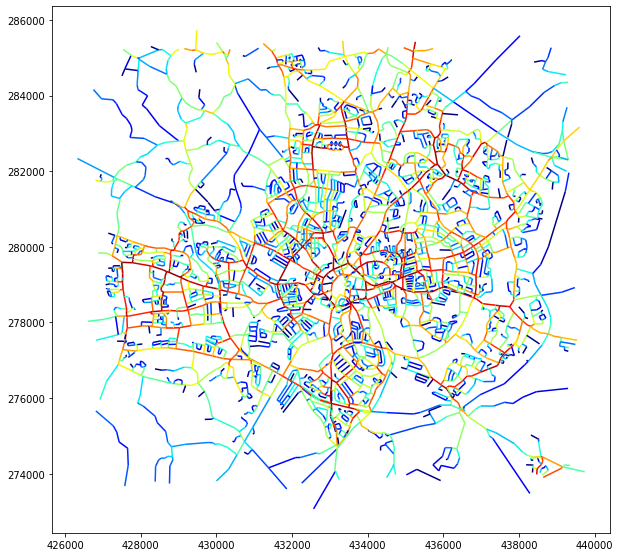

In [18]:
# Load dataset
meridian_fields = ['meridian_id', 'meridian_gid', 'meridian_code',
                   'meridian_osodr', 'meridian_number', 'meridian_road_name',
                   'meridian_indicator', 'meridian_class_scale']
census_geom_fields = ['oa11cd', 'wz11cd', 'lsoa11cd', 'lsoa11nm', 'msoa11cd', 'msoa11nm',
                      'lad11cd', 'lad11nm']
misc_fields = ['id']
ignore_fields = meridian_fields + census_geom_fields + misc_fields


loaded_gdfs = {}
def load_gdf(place=training_place): #(W, S, E, N)
  if place in loaded_gdfs:
    return loaded_gdfs[place]
  bounds = proj_and_reorder_bounds(bboxes[place])
  gdf = gpd.read_file('./OpenMapping-gb-v1_gpkg/gpkg/ssx_openmapping_gb_v1.gpkg',
                      bbox=bounds, ignore_fields=ignore_fields)
  loaded_gdfs[place] = gdf
  return gdf

from fiona.errors import DriverError
try:
  gdf = load_gdf()
except DriverError:
  # Download GeoPackage from Space Syntax
  !wget https://github.com/spacesyntax/OpenMapping/releases/download/gb-v1/ssx_OpenMapping_gb_v1_gpkg.zip
  !unzip ssx_OpenMapping_gb_v1_gpkg.zip
  gdf = load_gdf()

print(f'{gdf.size} geometries retrieved with the following attributes')
print(gdf.dtypes)
f, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(ax=ax, column='choice2kmrank', cmap='jet')

# Data preprocessing

In [19]:
# Graph Feature Processing
import momepy
from matplotlib import cm, colors
from shapely.geometry import LineString
from sklearn.preprocessing import OneHotEncoder

G = momepy.gdf_to_nx(gdf, approach='dual')
print(f'Generated graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges')
NUM_GEOM = 5

def centroid_generation(g):
    pos = {}
    for e, d in g.nodes(data=True):
        mid = d['geometry'].centroid
        pos[e] = {'midpoint': np.array([mid.x, mid.y])}
    nx.set_node_attributes(g, pos)
    pass

def centroid_subtraction(g):
    for _, d in g.nodes(data=True):
        d['geom'] = d['geom'] - d['midpoint']
    pass

def generate_geometries(g, attr_name='geom', verbose=0):
    steps = NUM_GEOM
    if verbose > 0:
        print('\nGenerating fixed length (%d) geometry vectors...' % (steps))
    geoms = nx.get_node_attributes(g, 'geometry')
    np_same_length_geoms = {}
    count_no = 0
    count_yes = 0
    for e in g.nodes():
        points = []

        if e not in geoms:  # edges that don't have a geometry
            raise ValueError('Why?')
            line = LineString([(xs[e[0]], ys[e[0]]), (xs[e[1]], ys[e[1]])])
            for step in np.linspace(0, 1, steps):
                point = line.interpolate(step, normalized=True)
                points.append([point.x, point.y])
            count_no += 1

        else:  # all other edges
            for step in np.linspace(0, 1, steps):
                point = geoms[e].interpolate(step, normalized=True)
                points.append([point.x, point.y])
            count_yes += 1
        np_same_length_geoms[e] = np.array([np.array((p[0], p[1])) for p in points])

    if verbose > 0:
        print('- Geometry inserted from intersection coordinates for', count_no, 'nodes.')
        print('- Standardized geometry created for', count_no + count_yes, 'nodes.')

    nx.set_node_attributes(g, np_same_length_geoms, attr_name)
    if verbose > 0:
        print('Done.')
    pass

def one_hot_encode_meridian_class(g):
    labels_standard = set()
    labels = nx.get_node_attributes(g, 'meridian_class')
    labels_int = {}
    
    for edge in g.nodes():
        label = labels[edge]
        labels_int[edge] = label
        labels_standard.add(label)

    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(np.array(list(labels_standard)).reshape(-1, 1))

    print('- One-hot encoder fitted to data with following categories:')
    print('-', np.array(enc.categories_).flatten().tolist())

    labels_one_hot = {k: enc.transform(np.array(v).reshape(1, -1)).toarray().flatten().tolist() for k, v in
                         labels_int.items()}

    nx.set_node_attributes(g, labels_one_hot, 'class_one_hot')
    pass

# Not resorting to this for now
# def bin_and_one_hot_encode_target(g, num_classes, rad='2km', mod=''):
#     _, target_attr = get_attrs(rad, mod)
#     target_attrs = nx.get_node_attributes(g, target_attr).values()
#     hist = np.histogram(target_attrs, bins=num_classes)

#     for 

def set_graph_features(g, rad='2km', mod=''):
    node_attrs, target_attr = get_attrs(rad, mod)

    # delete unused features
    for _, d in g.nodes(data=True):
        feats = {} # temporary dict
        feats['metres'] = d['metres']
        feats['mid_x'] = d['midpoint'][0]
        feats['mid_y'] = d['midpoint'][1]
        for i in range(NUM_GEOM):
          feats[f'geom{i}_x'] = d['geom'][i][0]
          feats[f'geom{i}_y'] = d['geom'][i][1]
        feats['y'] = d[target_attr]

        d.clear()
        for k in feats:
          d[k] = feats[k]
        
    
    # for _, d in g.edges(data=True):
    #     # flatten the attributes into a single array
    #     feats = 
    #     target = d[target_attr]
    #     d.clear()
        
    #     d['x'] = feats
    #     d['y'] = target
    pass

def process_graph(g, rad='2km', mod='', verbose=0):
    # geometry labelling
    # one_hot_encode_meridian_class(g)
    generate_geometries(g, verbose=verbose)
    centroid_generation(g)
    centroid_subtraction(g)
    set_graph_features(g, rad, mod)

    return g

def get_attrs(rad='2km', mod=''):
    curr_attrs = [f'nodecount{rad}', f'integration{rad}{mod}']
    attr_dict = {
        '2km': ['log', 'rank'],
        '10km': ['log', 'rank'],
        '100km': ['log']
    }
    mods = attr_dict[rad]
    if mod not in mods + ['']:
      raise KeyError(f'Invalid modifier {mod} for radius {rad}')
    target_attr = f'choice{rad}{mod}'
    base_attrs = ['metres', 'mid_x', 'mid_y'] + \
     [g for i in range(NUM_GEOM) for g in (f'geom{i}_x', f'geom{i}_y')]
    node_attrs = base_attrs + curr_attrs
    
    return node_attrs, target_attr

Generated graph with 6133 nodes and 10715 edges


In [20]:
import collections
def count_frequency(my_list):
    # Creating an empty dictionary
    freq = {}
    for item in my_list:
        if type(item) == list:
            item = item[0]
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1
    od = collections.OrderedDict(sorted(freq.items()))

    for key, value in od.items():
        print(f'{key}: {value}')


def print_class_distribution(g):
    labels = nx.get_edge_attributes(g, 'meridian_class')
    count_frequency((list(labels.values())))

In [21]:
G_processed = process_graph(G, rad='2km', mod='rank')
from itertools import chain
# List node and edge attributes
node_attrs = set(chain.from_iterable(d.keys() for *_, d in G.nodes(data=True)))
edge_attrs = set(chain.from_iterable(d.keys() for *_, d in G.edges(data=True)))
print(f'Node attributes: {node_attrs}, Edge Attributes: {edge_attrs}')
print_class_distribution(G)

Node attributes: {'geom1_y', 'y', 'mid_y', 'metres', 'geom3_y', 'mid_x', 'geom0_x', 'geom2_y', 'geom4_y', 'geom1_x', 'geom3_x', 'geom4_x', 'geom2_x', 'geom0_y'}, Edge Attributes: {'angle'}


# Data Loading

In [22]:
# General use dataloader
loaded_graphs = {}

def load_graph(place, rad='2km', mod='rank', split=False, batch_size=32, num_parts=1, verbose=False):
  key = (place, mod)
  if key in loaded_graphs:
    g = loaded_graphs[key]
  else:
    gdf = load_gdf(place)
    G = momepy.gdf_to_nx(gdf, approach='dual')
    if verbose:
      print(f'Generated graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges')
    
    G_processed = process_graph(G, mod=mod)
    node_attrs, _ = get_attrs(rad, mod)
    g = from_networkx(G_processed, group_node_attrs=node_attrs, group_edge_attrs=['angle'])
    loaded_graphs[key] = g
  
  if split:
    # Assign train_mask, val_mask and test_mask to data
    from torch_geometric.transforms import RandomNodeSplit
    g = RandomNodeSplit()(g)

  if num_parts > 1:
    # Return ClusterLoader
    from torch_geometric.loader import ClusterData, ClusterLoader
    cluster_data = ClusterData(g_split, num_parts=num_parts)
    return g, ClusterLoader(cluster_data, batch_size=batch_size, shuffle=True)
  else:
    # Return normal DataLoader
    from torch_geometric.loader import DataLoader
    return g, DataLoader(g, batch_size=batch_size, shuffle=True)


In [23]:
from torch_geometric.utils.convert import from_networkx
from torch_geometric.transforms import LineGraph, RandomNodeSplit
from torch_geometric.loader import ClusterData, ClusterLoader

# Convert into PyG graph data
node_attrs, _ = get_attrs('2km', 'rank')
print(node_attrs)
g = from_networkx(G_processed, group_node_attrs=node_attrs, group_edge_attrs=['angle'])
num_nodes = g.num_nodes
print(f'PyG graph has {g.num_nodes} nodes and {g.num_edges} edges')
print(f'There are {g.num_node_features} node features and {g.num_edge_features} edge features')

# Assign train and validation nodes. No test nodes assigned.
tfs = RandomNodeSplit(num_val=0.2, num_test=0)
g_split = tfs(g)

# Load into DataLoader
cluster_data = ClusterData(g_split, num_parts=128)  # 1. Create subgraphs.
train_loader = ClusterLoader(cluster_data, batch_size=32, shuffle=True)  # 2. Stochastic partioning scheme.

print()
total_num_nodes = 0
for step, sub_data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of nodes in the current batch: {sub_data.num_nodes}')
    print(sub_data)
    print(f'Node features:')
    print(sub_data.num_node_features)
    print()
    total_num_nodes += sub_data.num_nodes

print(f'Iterated over {total_num_nodes} of {g_split.num_nodes} nodes!')

['metres', 'mid_x', 'mid_y', 'geom0_x', 'geom0_y', 'geom1_x', 'geom1_y', 'geom2_x', 'geom2_y', 'geom3_x', 'geom3_y', 'geom4_x', 'geom4_y', 'nodecount2km', 'integration2km']


KeyError: 'nodecount2km'

# Models

In [24]:
from torch_geometric.nn import Linear, GCNConv, GATConv, SAGEConv


class LR(torch.nn.Module):
    def __init__(self, in_feats, num_classes):
        super().__init__()
        self.linear = Linear(in_feats, num_classes)

    def forward(self, x, graph):
        return self.linear(x)

class MLP(torch.nn.Module):
    def __init__(self, in_feats, h_feats, num_layers, num_classes):
        super().__init__()
        assert num_layers >= 1
        channel_list = [h_feats] * (num_layers - 1)
        channel_list = [in_feats] + channel_list + [num_classes]
        self.layers = [Linear(*dims) for dims in zip(channel_list[:-1], channel_list[1:])]

    def forward(self, data, graph):
        x = self.layers[0](x)
        for layer in layers[1:]:
          x = F.relu(x)
          x = F.dropout(x, training=self.training)
          x = layer.forward(x)
        return x

# class GCN(torch.nn.Module):
#     def __init__(self, in_feats, h_feats, num_layers, num_classes):
#         super().__init__()
#         self.layers = [GCNC]
#         self.conv1 = GCNConv(in_feats, h_feats)
#         self.conv2 = GCNConv(h_feats, num_classes)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index

#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)

#         return F.log_softmax(x, dim=1)

# class GAT(torch.nn.Module):
#     def __init__(self, in_feats, h_feats, num_classes):
#         super().__init__()
#         self.conv1 = GATConv(in_feats, h_feats)
#         self.conv2 = GATConv(h_feats, num_classes)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index

#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)

#         return F.log_softmax(x, dim=1)

# class SAGE(torch.nn.Module):
#     def __init__(self, ):
#         super().__init__()
#         self.conv1 = SAGEConv(dataset.num_node_features, 16)
#         self.conv2 = SAGEConv(16, dataset.num_classes)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index

#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)

#         return F.log_softmax(x, dim=1)

In [25]:
# https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=20, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Training loop

In [26]:
from sklearn.metrics import r2_score

USE_GPU = True
dtype = torch.float32 


if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)

def train(model, optimizer, criterion):
    model.train()
    for data in train_loader:  # Iterate over each mini-batch.
        data = data.to(device)
        out = model(data.x.float(), data.edge_index).squeeze(1)  # Perform a single forward pass.
        loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(trained_model, loader, r2=False, masked=False):
    trained_model.eval()
    
    if r2:
      # Treat loader as Data object
      loader = loader.to(device)
      pred = trained_model(loader.x.float(), loader.edge_index)
      if masked:
        return [r2_score(loader.y[mask], pred[mask]) for mask in
                [loader.train_mask, loader.val_mask]]
      else:
        return r2_score(loader.y.detach(), pred.detach())

    # Calculate MAE
    error = [0, 0] if masked else 0
    num_samples = [0, 0]
    for data in loader:
      data = data.to(device)
      pred = trained_model(data.x.float(), data.edge_index).squeeze(1)
      if masked:
        for i, mask in enumerate([data.train_mask, data.val_mask]):
            error[i] += (pred[mask] - data.y[mask]).abs().sum().item()
            num_samples[i] += len(pred[mask])
      else:
        error += (pred - data.y).abs().sum().item()

    if masked:
      return error[0] / num_samples[0], error[1] / num_samples[1]
    else:
      return error / len(loader.dataset)


cuda:0


In [27]:
from torch_geometric.nn import GCN, GAT, GraphSAGE
num_feats = g_split.num_node_features
num_classes = 1
hidden_channels = 16
num_layers = 5
model = GCN(num_feats, hidden_channels, num_layers, num_classes, jk='cat', act=nn.Sigmoid())
# model = MLP()
model = model.to(device)
optimizer = torch.optim.Adamax(model.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, cooldown=5, min_lr=1e-7, verbose=True)
criterion = torch.nn.MSELoss()

train_losses = []
val_losses = []
early_stopping = EarlyStopping(patience=20, verbose=False)
epochs = 10000
for epoch in range(1, epochs + 1):
    loss = train(model, optimizer, criterion)
    train_loss, val_loss = test(model, train_loader, masked=True)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch: {epoch:03d}, Train: {train_loss:.4f}, Val: {val_loss:.4f}')
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.show()

NameError: name 'g_split' is not defined

# Test model against unseen graph

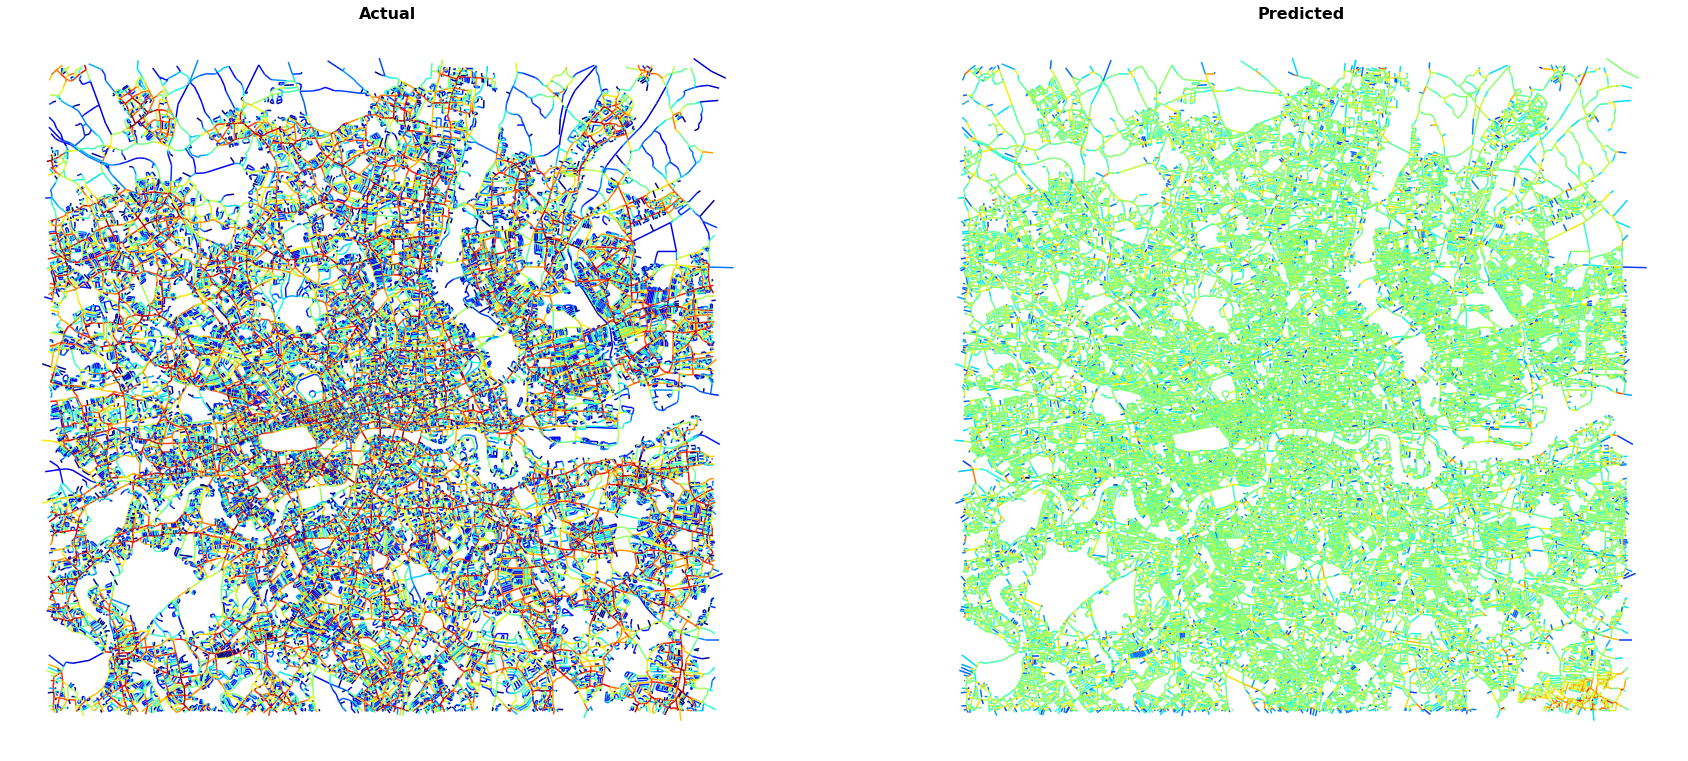

In [ ]:
# def add_preds_to_attrs(primal_graph, dual_graph, model):
#    graph = graph.to(device)
#    pred = trained_model(loader.x.float(), loader.edge_index)
   
#    pred_dict = {}
#    for e in primal_graph.edges():
#         points = []
#         if e not in geoms:  # edges that don't have a geometry
#             line = LineString([(xs[e[0]], ys[e[0]]), (xs[e[1]], ys[e[1]])])
#             for step in np.linspace(0, 1, steps):
#                 point = line.interpolate(step, normalized=True)
#                 points.append([point.x, point.y])
#             count_no += 1

#         else:  # all other edges
#             for step in np.linspace(0, 1, steps):
#                 point = geoms[e].interpolate(step, normalized=True)
#                 points.append([point.x, point.y])
#             count_yes += 1
#         pred_dict[e] = np.array([np.array((p[0], p[1])) for p in points])
#    nx.set_edge_attributes(primal_graph, pred_dict)

def visualize_preds(place, model, mod=''):
  loader, _ = load_graph(place, mod=mod)
  gdf = load_gdf(place)
  streets = momepy.gdf_to_nx(gdf, approach='dual')
  
  # Convert nx graph to dgl (preserves node order) and get model predictions 
  loader = loader.to(device)
  preds = model(loader.x.float(), loader.edge_index)
  
  # Assign prediction to nx attribute
  pred_dict = {}
  for i, e in enumerate(streets.nodes()):
    pred_dict[e] = preds[i].item()
  nx.set_node_attributes(streets, pred_dict, 'preds')

  # Convert nx graph back to gdf and plot actual and predicted values
  lines = momepy.nx_to_gdf(streets)
  f, ax = plt.subplots(1, 2, figsize=(30, 15), sharex=True, sharey=True)
  for i, facet in enumerate(ax):
      facet.set_title(("Actual", "Predicted")[i], fontweight="bold", size=16)
      facet.axis("off")
  lines.plot(ax=ax[0], column='choice2kmrank', cmap='jet')
  lines.plot(ax=ax[1], column='preds', cmap='jet')

visualize_preds('london', model)


# Documentation...


In [ ]:
print(f'Training loss ({training_place}): {test(model, g_split, r2=True)}')
for place in bboxes:
  if place is not training_place:
    print(f'Testing {place}')
    test_graph, _ = load_graph(place, mod='', verbose=True)
    print(f'Loss: {test(model, test_graph, r2=True)}')

NameError: ignored